## Good Notebook to use as reference


- http://jpfairbanks.net/2017/07/15/email-topics-with-nmf/

# Topic Modeling LSA/I, probabilistic LSA / NMF

## Imports

In [2]:
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

In [3]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC Data

In [4]:
path = Path('bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        _, topic, file_name = file.parts

        lines = f.readlines()
        file_id = file_name.split('.')[0]
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic, heading, body])

## Convert to DataFrame

In [6]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
article    2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


## Inspect results

In [7]:
docs.sample(10)

,topic,heading,article
750,entertainment,Youssou N'Dour wins music prize,Senegalese musician Youssou N'Dour has been n...
1250,politics,Lib Dems stress Budget trust gap,Public trust in the handling of the economy c...
1506,sport,Klinsmann issues Lehmann warning,Germany coach Jurgen Klinsmann has warned goa...
1143,politics,David Blunkett in quotes,David Blunkett - who has resigned as home sec...
1735,sport,Ferrero eyes return to top form,Former world number one Juan Carlos Ferrero i...
1427,sport,Giggs handed Wales leading role,Ryan Giggs will captain Wales as he wins his ...
545,entertainment,Hanks greeted at wintry premiere,Hollywood star Tom Hanks was in London's Leic...
475,business,Saudi NCCI's shares soar,Shares in Saudi Arabia's National Company for...
1351,sport,Jones medals 'must go if guilty',World Anti-Doping Agency (WADA) chief Dick Po...
653,entertainment,Eminem beats Elvis to number one,Rapper Eminem has denied Elvis his fourth num...


# Data drawn from 5 different categories

In [8]:
docs.topic.value_counts(normalize=True)

sport           0.23
business        0.23
politics        0.19
tech            0.18
entertainment   0.17
Name: topic, dtype: float64

# Prepare Document-Term Matrix

In [9]:
print(CountVectorizer().__doc__)

Convert a collection of text documents to a matrix of token counts

    This implementation produces a sparse representation of the counts using
    scipy.sparse.csr_matrix.

    If you do not provide an a-priori dictionary and you do not use an analyzer
    that does some kind of feature selection then the number of features will
    be equal to the vocabulary size found by analyzing the data.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : string {'filename', 'file', 'content'}
        If 'filename', the sequence passed as an argument to fit is
        expected to be a list of filenames that need reading to fetch
        the raw content to analyze.

        If 'file', the sequence items must have a 'read' method (file-like
        object) that is called to fetch the bytes in memory.

        Otherwise the input is expected to be the sequence strings or
        bytes items are expected to be analyzed directly.

    encoding

# Baseline document-term matrix

In [10]:
# Baseline: number of unique tokens
vectorizer = CountVectorizer() # default: binary=False
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [11]:
doc_term_matrix.shape

(2225, 29275)

# Inspect tokens

In [12]:
# vectorizer keeps words
words = vectorizer.get_feature_names()
words[:10]

['00',
 '000',
 '0001',
 '000bn',
 '000m',
 '000s',
 '000th',
 '001',
 '001and',
 '001st']

## Inspect doc-term matrix

In [13]:
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.SparseDataFrame(doc_term_matrix, columns=words)
doc_term_matrix_df.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Most frequent terms

In [14]:
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head() 

the    52574
to     24767
of     19930
and    18574
in     17553
dtype: int32

## Compute relative term frequency

In [15]:
vectorizer = CountVectorizer(binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 29275)

In [16]:
words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)

# reduce to 1D array
word_freq_1d = np.squeeze(np.asarray(word_freq))

pd.Series(word_freq_1d, index=words).div(
    docs.shape[0]).sort_values(ascending=False).head(10)

the    1.00
to     1.00
of     0.99
and    0.99
in     0.99
for    0.93
on     0.91
is     0.86
it     0.86
said   0.85
dtype: float64

## Visualize Doc-Term Matrix

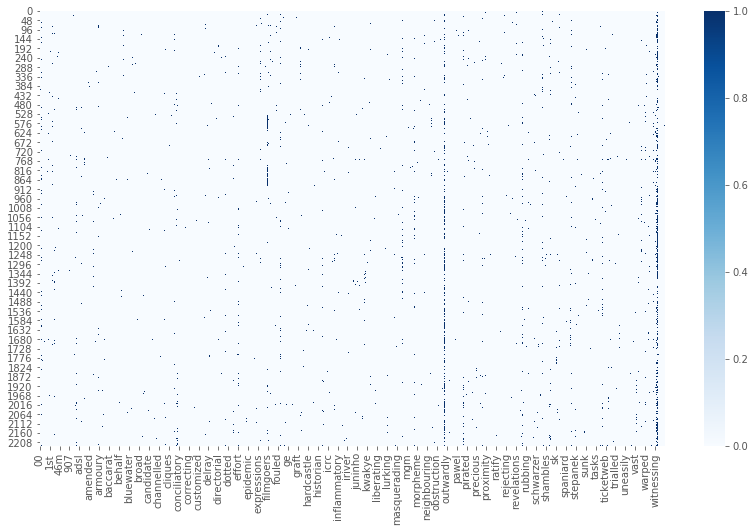

In [17]:
sns.heatmap(pd.DataFrame(doc_term_matrix.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(14, 8);

## Using thresholds to reduce the number of tokens

In [18]:
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 12789)

## Use CountVectorizer with Lemmatization

## Building a custom tokenizer for Lemmatization with spacy

In [20]:
nlp = spacy.load('en')
def tokenizer(doc):
    return [w.lemma_ for w in nlp(doc) 
                if not w.is_punct | w.is_space]

In [21]:
vectorizer = CountVectorizer(tokenizer=tokenizer, binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 25073)

In [22]:
lemmatized_words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=lemmatized_words).div(docs.shape[0])
word_freq_1d.sort_values().tail(20)

from     0.70
but      0.73
as       0.74
by       0.77
at       0.79
with     0.82
that     0.83
say      0.88
's       0.90
on       0.91
for      0.93
have     0.97
in       0.99
and      0.99
of       0.99
a        0.99
-PRON-   1.00
to       1.00
be       1.00
the      1.00
dtype: float64

Unlike verbs and common nouns, there's no clear base form of a personal pronoun. Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.

## TfIdf Vectorizer

In [19]:
print(TfidfTransformer().__doc__)

Transform a count matrix to a normalized tf or tf-idf representation

    Tf means term-frequency while tf-idf means term-frequency times inverse
    document-frequency. This is a common term weighting scheme in information
    retrieval, that has also found good use in document classification.

    The goal of using tf-idf instead of the raw frequencies of occurrence of a
    token in a given document is to scale down the impact of tokens that occur
    very frequently in a given corpus and that are hence empirically less
    informative than features that occur in a small fraction of the training
    corpus.

    The formula that is used to compute the tf-idf of term t is
    tf-idf(d, t) = tf(t) * idf(d, t), and the idf is computed as
    idf(d, t) = log [ n / df(d, t) ] + 1 (if ``smooth_idf=False``),
    where n is the total number of documents and df(d, t) is the
    document frequency; the document frequency is the number of documents d
    that contain term t. The effect of addi

In [24]:
tfidf = TfidfVectorizer()
doc_term_matrix = tfidf.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 29275)

In [25]:
words = tfidf.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=words)
word_freq_1d.sort_values().tail(20) 

are     53.42
have    54.73
as      55.83
has     56.23
with    57.27
will    57.99
be      63.05
was     68.57
on      75.63
said    78.80
it      79.05
he      79.85
that    82.59
is      84.27
for     84.30
in     165.16
and    166.06
of     177.76
to     221.14
the    475.64
dtype: float64

## Create Train & Test Sets

In [26]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [27]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [28]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
politics          9
entertainment     9
tech              9
Name: topic, dtype: int64

# Vectorize train & test sets

In [29]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178762 stored elements in Compressed Sparse Row format>

In [30]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4048 stored elements in Compressed Sparse Row format>

## Latent Semantic Analysis

In [31]:
svd = TruncatedSVD(n_components=5, n_iter=20, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=20,
       random_state=42, tol=0.0)

## Explore Topics

In [32]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 6)]

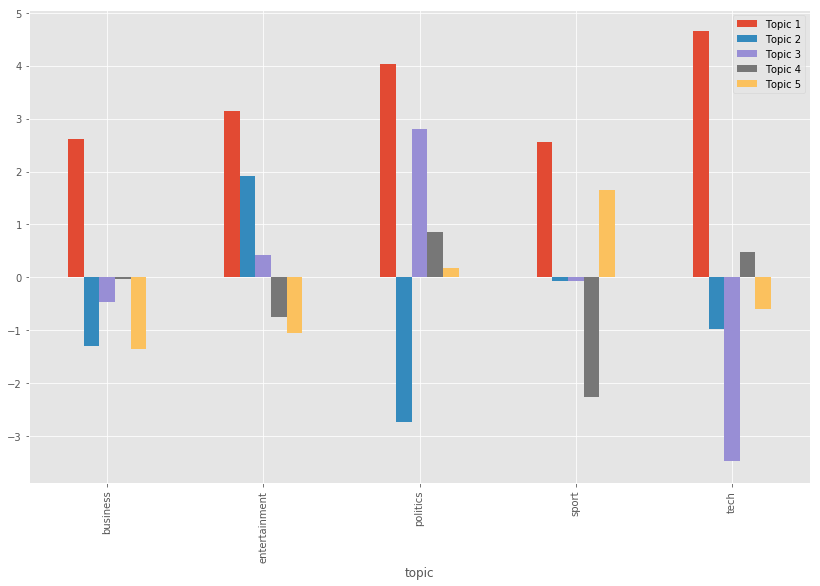

In [33]:
svd_result = pd.DataFrame(data=svd.transform(train_dtm),
                   columns=topic_labels,
                   index=train_docs.topic)
svd_result.groupby(level='topic').mean().plot.bar();

In [34]:
topics = pd.DataFrame(svd.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.07,-0.00,-0.01,-0.01,-0.01
100,0.02,-0.01,-0.01,0.01,-0.01
100m,0.00,-0.00,0.00,-0.01,-0.00
11,0.03,-0.00,-0.00,-0.02,-0.02
12,0.03,-0.01,-0.01,-0.02,-0.00


In [35]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,music,best,labour,music,music
1,best,music,party,urban,game
2,think,song,best,labour,urban
3,good,25,election,party,games
4,song,awards,blair,election,england
5,game,urban,brown,black,roddick
6,labour,robbie,song,mobile,party
7,british,won,minister,stone,play
8,games,award,kilroy,blair,kilroy
9,party,film,silk,digital,wales


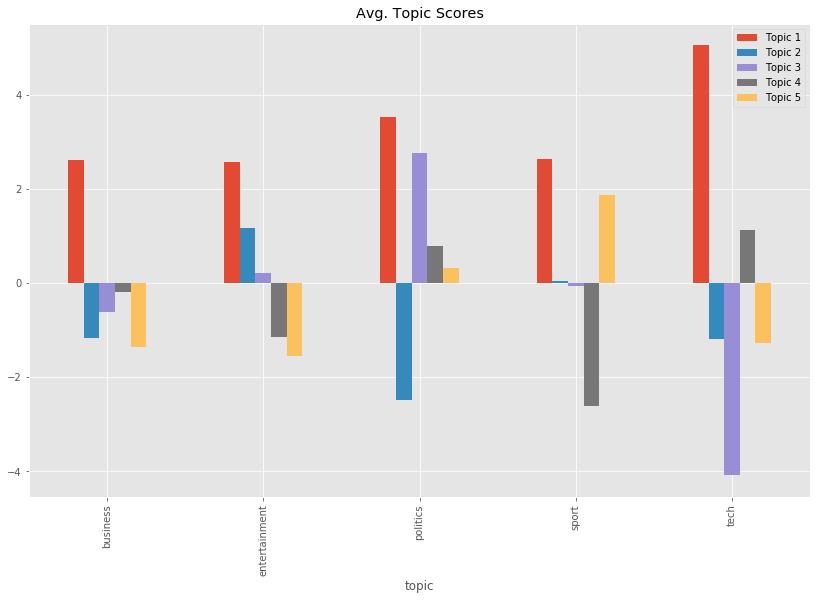

In [36]:
test_eval = pd.DataFrame(data=svd.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Scores');

## probabilistic Latent Semantic Analysis


## Implementation using Non-Negative Matrix Factorization

pLSI [has been shown](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.8839&rep=rep1&type=pdf) to be equivalent to Non-Negative Matrix Factorization with Kullback-Leibler Divergence objective.

In [37]:
nmf = NMF(n_components=5, random_state=42, solver='mu',
          beta_loss='kullback-leibler', max_iter=1000)
nmf.fit(train_dtm)
nmf.reconstruction_err_

1168.0979104854187

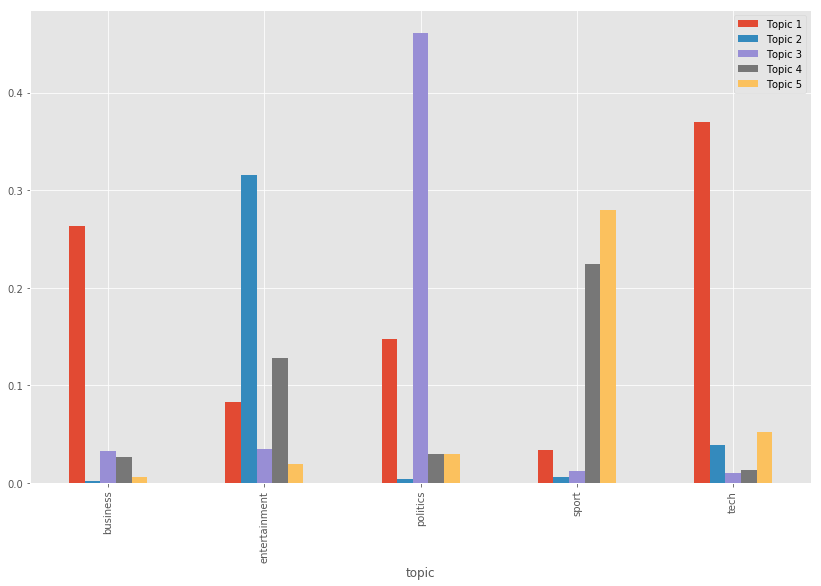

In [38]:
nmf_res = pd.DataFrame(data=nmf.transform(train_dtm),
                       columns=topic_labels,
                       index=train_docs.topic)
nmf_res.groupby(level='topic').mean().plot.bar();

In [39]:
topics = pd.DataFrame(nmf.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,1.01,0.00,0.00,0.75,0.00
100,0.50,0.00,0.00,0.00,0.00
100m,0.03,0.00,0.00,0.21,0.00
11,0.38,0.00,0.00,0.45,0.00
12,0.45,0.00,0.00,0.52,0.00


In [40]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,market,film,labour,won,game
1,company,best,election,second,england
2,says,music,party,final,games
3,work,awards,blair,open,play
4,firm,award,minister,best,players
5,use,won,brown,old,wales
6,million,band,public,took,half
7,technology,album,britain,win,win
8,2004,actor,howard,international,good
9,news,director,prime,champion,club


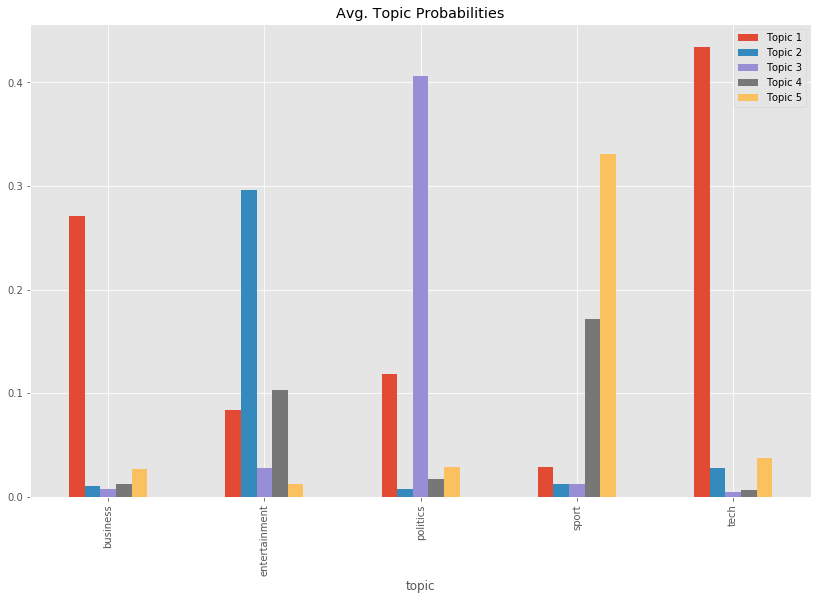

In [41]:
test_eval = pd.DataFrame(data=nmf.transform(test_dtm),
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(
    title='Avg. Topic Probabilities');

In [42]:
#environment and package versions
print('\n')
print("_"*70)
print('The environment and package versions used in this script are:')
print('\n')

import platform; print(platform.platform())
import sys;print('Python', sys.version)
import os;print('OS', os.name)
import numpy;print('Numpy', np.__version__)
import bs4;print('Beautiful Soup', bs4.__version__)
import urllib;print('Urllib', urllib.request.__version__) 
import re;print('Regex', re.__version__)
import spacy;print('SpaCy', spacy.__version__)
import gensim;print('Gensim', gensim.__version__)
import sklearn;print('Sklearn', sklearn.__version__)
import scipy;print('Scipy', scipy.__version__)
import matplotlib;print('Matplotlib', matplotlib.__version__)
print (os.environ['CONDA_DEFAULT_ENV'])

print('\n')
print("~"*70)
print('\n')



______________________________________________________________________
The environment and package versions used in this script are:


Windows-10-10.0.17134-SP0
Python 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
OS nt
Numpy 1.15.4
Beautiful Soup 4.6.3
Urllib 3.6
Regex 2.2.1
SpaCy 2.0.12
Gensim 3.5.0
Sklearn 0.19.2
Scipy 1.1.0
Matplotlib 3.0.1
py36_text_analytics


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


